# LSTM Implementation for Sentiment Analysis on Amazon Product Reviews

# Prerequisites

1. The code blocks below can work perfectly with Google Colab. Colab allows anybody to write and execute arbitrary python code through the browser, and is especially well suited to machine learning, data analysis and education.

2. Incase you donot want to work on Colab, you can simply start from the heading "Importing Libraries", but you need to have train.ft.txt.bz2 and test.ft.txt.bz2 in the same directory. 

# Downloading DATASET from Kaggle


Following steps are carried out in the code block below.

1. The dataset is downloaded from Kaggle, link is provided in the project proposal. 

2. The user needs to upload a kaggle.jason which can be generated from the user's kaggle  account. 

In [1]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d bittlingmayer/amazonreviews

Saving kaggle.json to kaggle.json
 99% 489M/493M [00:30<00:00, 30.4MB/s]
100% 493M/493M [00:30<00:00, 16.8MB/s]


# Making a Directory and Unzipping files

Following steps are carried out in the code block below,

1. Making a new directory and calling it train in colab. 

2. Unziping the file downloaded from kaggle into this directory. 

In [2]:
! mkdir train
! unzip amazonreviews.zip -d train

Archive:  amazonreviews.zip
  inflating: train/test.ft.txt.bz2   
  inflating: train/train.ft.txt.bz2  


# Importing Libraries

Multiple libraries are included in the code block below, specially some tensorflow packages are imported for setting up LSTM model, and some for converting the preprocessed data to a form which LSTM model can understand. Apart from these some nltk packages are used for stemming and removal of stopwords as they donot contribute to the sentiment analysis.  

In [3]:
import numpy as np 
import pandas as pd 
import bz2 as bz
import csv
import re
import string
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, Embedding
from tensorflow.keras.models import Model
import gc
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dropout
from sklearn.metrics import roc_auc_score, confusion_matrix, f1_score, roc_curve
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import SnowballStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Navigating to the directory with datasets

Navigating to the directory into which downloaded files were unzipped, this step can be skipped if you are not using Colab and have the dataset in your directory as explained in the Prerequisites heading above. 

In [4]:
%cd /content/train

/content/train


# Data Formatting



Since the training dataset an testing dataset is already provided in seperate folders, they are processed using the following functions in the code block below.

1. The bz2 file is decompressed

2. .readlines() function returns a list, by reading each line of the file as a list item.

3. .decode() takes in the encoded string and returns the original string, list comprehension is used for clarity. 

In [5]:
train_data = bz.BZ2File("train.ft.txt.bz2")                               # Decompressing bz2 file
train_data = train_data.readlines()                                       # Convert all lines of the files into list enteries
train_data = [x.decode('utf-8') for x in train_data]                      # List Comprehension is used, to decode the data

#Similar steps are adopted for test data below. 

test_data = bz.BZ2File("test.ft.txt.bz2")
test_data = test_data.readlines()
test_data = [x.decode('utf-8') for x in test_data]

The datasets which are now in stored in lists are converted to pandas dataframes in the code block below and previous variables are deleted using 'del' operator, and 
gc.collect() is used to clear up the memory. 

In [6]:
# Converting lists to dataframes and deleting the useless variables from memory to avoid memory overflow. 

train_data_df = pd.DataFrame(train_data)
del train_data
test_data_df = pd.DataFrame(test_data)
del test_data
gc.collect()

0

A column name is assigned to both dataframes i.e. one with training data and one with test data. 

Dataframe corresponding to test data is shown in the output. It has 400k rows, and just for information the training dataframe has 3.6M rows.

In [7]:
# A column name is assigned to both dataframes, "String"
# This string contains both Label and Review, we will seperate them soon. 

train_data_df.rename(columns={0: 'String'},inplace=True)
train_data_df.dropna()

test_data_df.rename(columns={0: 'String'},inplace=True)
test_data_df.dropna()

#The testdata's dataframe is visible below as output, it has 400k Rows, where as training data has 3.6 Million rows

,String
0,__label__2 Great CD: My lovely Pat has one of ...
1,__label__2 One of the best game music soundtra...
2,__label__1 Batteries died within a year ...: I...
3,"__label__2 works fine, but Maha Energy is bett..."
4,__label__2 Great for the non-audiophile: Revie...
...,...
399995,__label__1 Unbelievable- In a Bad Way: We boug...
399996,"__label__1 Almost Great, Until it Broke...: My..."
399997,__label__1 Disappointed !!!: I bought this toy...
399998,__label__2 Classic Jessica Mitford: This is a ...


Following steps will be done in the code block below.

1. After looking at the dataset it can observed that we need to make a split each cell of the Column 'String', this needs to done inorder to split the "LABELS" from "REVIEWS". 

2. Considering the above information 2 more columns are added to the above dataframes (train and test both). These columns are created by making a split at the first space (" "), in the string, by using str.split() function.

3. The del operator is used to delete the String Column as we donot need it anymore

4. The labels are mentioned in a specific format, for ease of processing we will just binarize the labels, as in 

=> **0 = "__label__1"**  : *Negative Review*

=> **1 = "__label__2"**  : *Positive Review*

In [8]:
train_data_df[['Label','Review']] = train_data_df.String.str.split(" ",expand=True,n = 1)          # Split the "Strngs column"
del train_data_df["String"]                                                                        # Delete the old column
train_data_df = train_data_df.replace({'Label': {'__label__1': 0, '__label__2': 1}})               # Binarize Labels

#Similar steps are adopted for test data below

test_data_df[['Label','Review']] = test_data_df.String.str.split(" ",expand=True,n = 1)
del test_data_df["String"]
test_data_df = test_data_df.replace({'Label': {'__label__1': 0, '__label__2': 1}})

gc.collect() is called again to free the objects that are collectable and the first 5 enteries of the test dataframe is printed. 

It can be observed, *Negative Reviews are represented by 0* and *Positive Reviews are represented by 1*.  

In [9]:
gc.collect()                                                # Clears up memory by freeing the objects that are collectable
test_data_df.head()                                         # First 5 enteries of the test dataframe is printed

,Label,Review
0,1,Great CD: My lovely Pat has one of the GREAT v...
1,1,One of the best game music soundtracks - for a...
2,0,Batteries died within a year ...: I bought thi...
3,1,"works fine, but Maha Energy is better: Check o..."
4,1,Great for the non-audiophile: Reviewed quite a...


The first 5 enteries of the train dataframe are printed in the code block below. 

(Apparently all of the first five enteries are positive reviews)

In [10]:
train_data_df.head()                                        #  first 5 enteries of the train dataframe are printed

,Label,Review
0,1,Stuning even for the non-gamer: This sound tra...
1,1,The best soundtrack ever to anything.: I'm rea...
2,1,Amazing!: This soundtrack is my favorite music...
3,1,Excellent Soundtrack: I truly like this soundt...
4,1,"Remember, Pull Your Jaw Off The Floor After He..."


# Feature Engineering 

### Cleaning and Stemming 

In the code block below, cleanText() is defined to perform the preprocessing on the raw data, this function does the following tasks,

1. Removes Punctuation.

2. Removes Stopwords.

3. Performs stemming. 


and **What is Stemming ?** 

Stemming is the process of reducing inflected (or sometimes derived) words to their word stem, base or root form—generally a written word form. The stem need not be identical to the morphological root of the word; it is usually sufficient that related words map to the same stem, even if this stem is not in itself a valid root. [1]

In [11]:
# Fetch stopwords from NTLK and stemming
word_stemmer = SnowballStemmer("english", ignore_stopwords=False)

# Creating a set of stopwords
stopWords = set([word for word in set(stopwords.words('english'))])


# Defining a function to clean up the text (removing new line symbols etc)
def cleanText(text):
    """
    Input: Unprocessed Data, containing punctuation, stopwords etc. i.e. Column with Reviews
    Output: Processed data, with useless information stripped off.
    """
    
    text = text.replace('\n', ' ').strip().lower()
    # Remove any symbols
    text = re.sub(r'[^a-zæøåéäö ]+', '', text)
    # Remove consecutive whitespaces
    text = re.sub(r'\s\s+', ' ', text)
    # Removing stopwords in the text and stemming the words. 
    text = ' '.join([word_stemmer.stem(word) for word in text.split()
                     if word not in stopWords])
    return text

In the code blocks below, the above defined function is called and implemented on the Review column dataframe containing training data. 

In [12]:
train_data_df.Review = [cleanText(str(r)) if str(r) != 'nan' else '' for r in train_data_df.Review]  

In [13]:
train_data_df.head()

,Label,Review
0,1,stune even nongam sound track beauti paint sen...
1,1,best soundtrack ever anyth im read lot review ...
2,1,amaz soundtrack favorit music time hand intens...
3,1,excel soundtrack truli like soundtrack enjoy v...
4,1,rememb pull jaw floor hear youv play game know...


In the code blocks below, the above defined function is called and implemented on the Review column dataframe containing test data.

In [14]:
test_data_df.Review = [cleanText(str(r)) if str(r) != 'nan' else '' for r in test_data_df.Review]

In [15]:
test_data_df.tail()

,Label,Review
399995,0,unbeliev bad way bought thoma son huge thoma f...
399996,0,almost great broke son reciev birthday gift mo...
399997,0,disappoint bought toy son love thoma toy need ...
399998,1,classic jessica mitford compil wide rang mitfo...
399999,0,comedi scene heard dvd disappoint get hope see...


### Tokenization

Looking at the dataframe above we can still make some sense out of it after stemming, but we have to convert our data into a form which can be processed by our LSTM model. This process is called *tokenization*, there is a TensorFlow api for doing this process.  

We will discuss tokenization process briefly below, with some images and examples learned from TensorFlow channel on YouTube. [2]

Lets take an example, we want to encode a sentence, **"I love my dog"**.

We can simply do the following simple encoding for this process. 

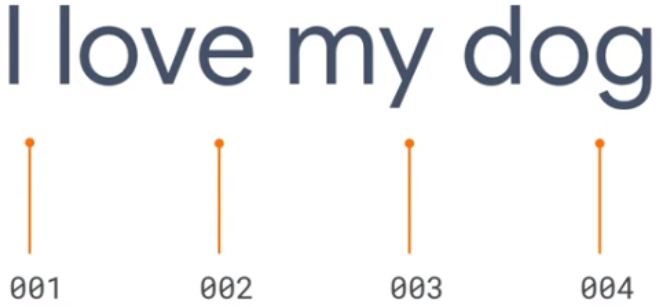

We just assigned 1,2,3,4 to the words in the sentence *"I love my dog"* sequentially. Lets say we have another sentence. **"I love my cat"**.

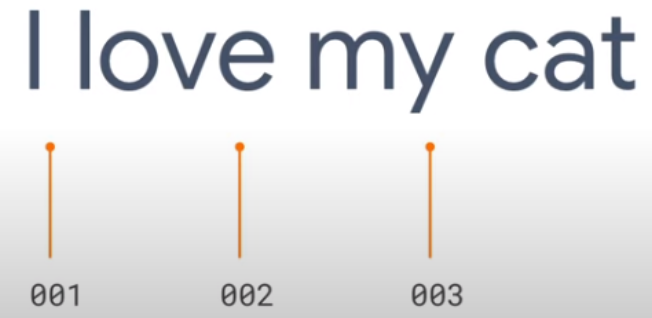

It can be seen the first 3 words were already, encoded earlier, we can just need to encode the last word, as done below.

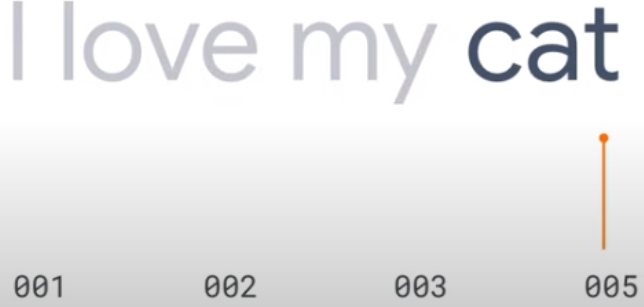




Now if we look at the two sentences, they are represented as,

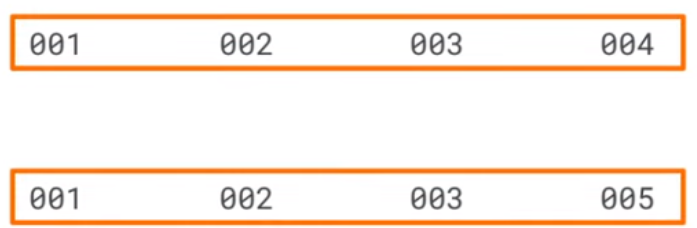

We can already, see some kind of similarity in the sentences after the encoding, because oth sentences are about loving a pet.  

Keeping this in mind, lets explain the tokenization process by looking at the code below.

Tokenizer is a imported from *tensorflow.keras.preprocessing.text.Tokenizer*, it is a text tokenization utility class in keras.

Following steps are completed in the code block below,

1. A **Tokenizer class instance** named **tokenizer** is created, with **num_words set to 20000**, this represents the **maximum number of words to keep in tokenization process**. Imagine we had a a huge array of sentences, as we do have in this case (3.6 Million reviews for training the network), instead just the two examples discussed above. 

**Simply, this will just give us the most frequent 20,000 words in that list of 3.6M reviews, after we do the next step**.  

2. *tokenizer.fit_on_texts* is used to update internal vocabulary based on a list of texts in the case where texts contains lists, we assume each entry of the lists to be a token. The tokenizer is smart enough to overcome small issues, as shown below,

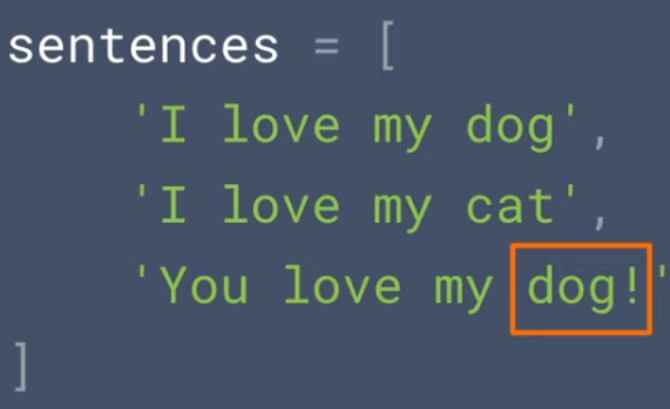

The tokenizer, does not creates a new object for **dog!**, same one is assigned for **dog** and **dog!** both. The result can be seen below as there is not token for **dog!** but their is one for **dog**.    

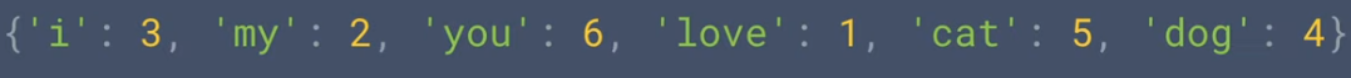

3. In the last steps, our tokenization process was completed. Now we will convert these numbers into ordered sequences then our data will be ready to sent as input to our Neural Network.  

4. *tokenizer.texts_to_sequences* is used to create sequences of tokens representing each sentence. For elaboration consider the following sentences,

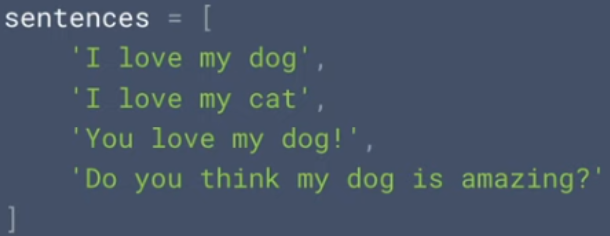

These sentences are converted to word-values pairs in a dictionary using *tokenizer.fit_on_texts*, this dictionary can be visualized by *tokenizer.word_index*. The dictionary can be seen below.

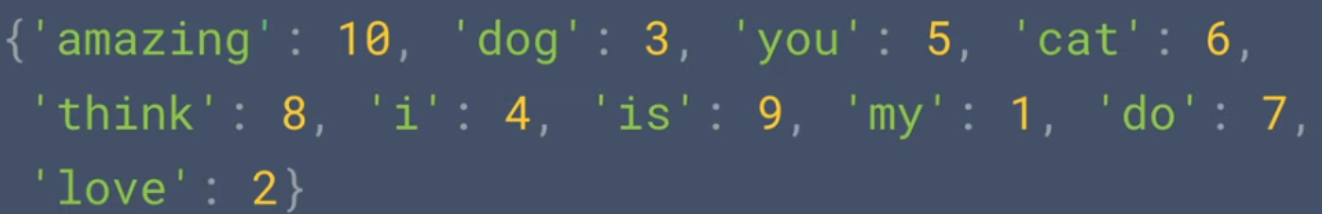

After performing, *tokenizer.texts_to_sequences* on the above example, following results are obtained..

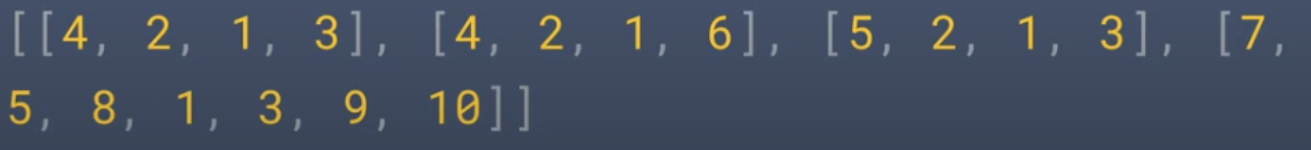

These results can be further elaborated  by **following the arrows in the figure below**, the first sequence makes up the first sentence, meaning **"I love my dog"**.

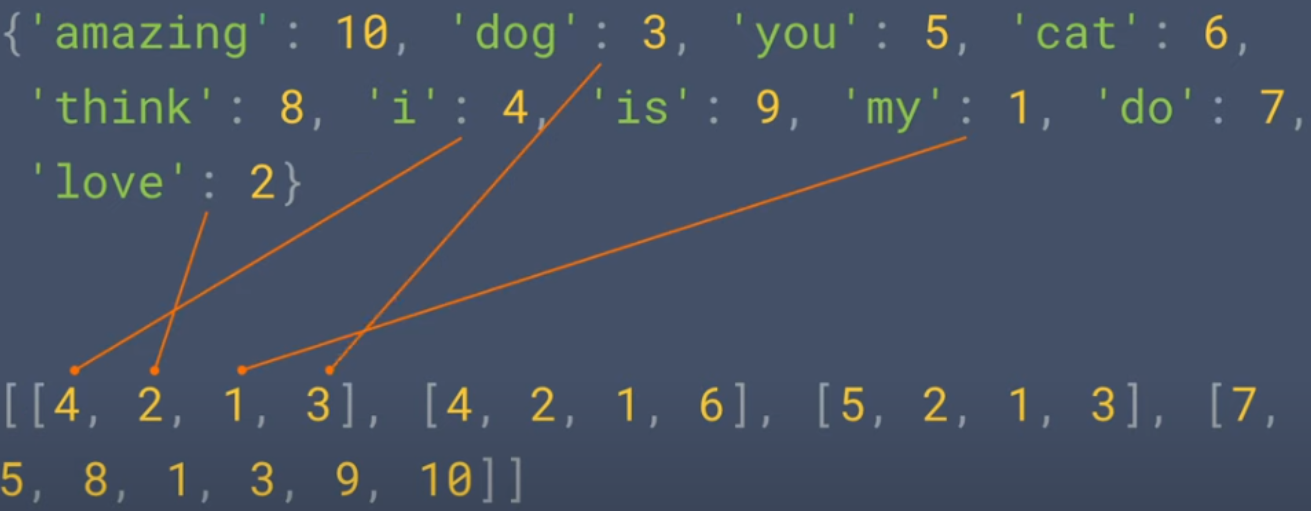


5. The sequencing operation is performed on both training data and test data. 


An important parameter in initialization of Tokenizer instance was oov_token, this is the out of vocabulary token, now since we show only the training data to our tokenizer, while building vocabulary, we make an additional token for out of vocabulary words.  

In [16]:
tokenizer = Tokenizer(num_words = 20000, oov_token = "<OOV>")
tokenizer.fit_on_texts(train_data_df.Review)

In [17]:
sequences_train = tokenizer.texts_to_sequences(train_data_df.Review)

In [18]:
sequence_test = tokenizer.texts_to_sequences(test_data_df.Review)

Taking our labels from training and test data

In [19]:
Y_train = train_data_df['Label'].values
Y_test  = test_data_df['Label'].values

Deletng the old dataframes from memory, they have served their purpose. 

In [20]:
del train_data_df
gc.collect()
del test_data_df
gc.collect()

0

The *full list of words* kept by tokenizer is available as **tokenzer's index property**. The result will be of type dictionary, with key = word and value being the token. 

For example, after running this on **"I love my dog"**, we may get,

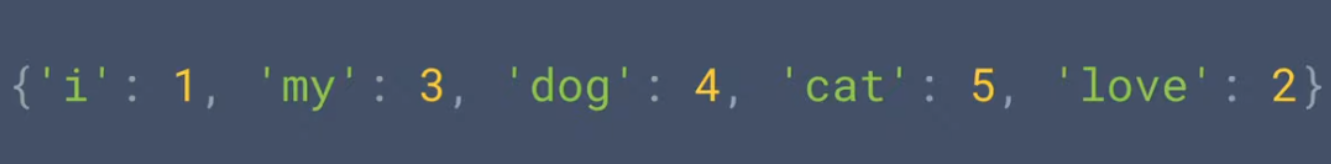

The number of unique tokens in dataset are shown below, i.e. 1870614. 

In [21]:
word2idx = tokenizer.word_index
V = len(word2idx)
print('Found %s unique tokens.' % V)

Found 1870614 unique tokens.


One may question the fact, that how will we handle the sentences of diifferent lengths, because naturally all the reviews will be of different lengths as they are made by different people regarding different products on amazon.

We will use pad_sequences which basically adds zero's infront of the sequence to make all sequence lengths equal to the maximum length (i.e. which is the length of the biggest review).

This padding can be done infront of the sequence, or after or the user can also define the maximum length and truncate the remaining encoded words.  

In [22]:
# pad sequences so that we get a N x T matrix
data_train = pad_sequences(sequences_train)
print('Shape of train data tensor:', data_train.shape)

# get sequence length
T = data_train.shape[1]

Shape of train data tensor: (3600000, 185)


Similar padding step is done for test data, the maxlen is defined to keep the dimensions same as training data. 

In [23]:
maxlen = max([len(x) for x in data_train])

data_test = pad_sequences(sequence_test, maxlen=maxlen)

The dimensions of test and training dataset, is shown as a result of code block below. 

In [24]:
#X_train,X_test,Y_train,Y_test = train_test_split(data_train,Y,test_size = 0.1,random_state = 42)
print("Shapes for training dataset",data_train.shape,Y_train.shape)
print("Shapes for testing dataset",data_test.shape,Y_test.shape)

Shapes for training dataset (3600000, 185) (3600000,)
Shapes for testing dataset (400000, 185) (400000,)


The useless variables and structures are deleted and memory is cleared.

In [25]:
del sequences_train
gc.collect()
del tokenizer
gc.collect()

0

### Word Embedding Process by using Keras Embedding Layer

*Word embeddings* are a type of word representation that **allows words with similar meaning to have a similar representation**. They are an **improvement over sparse representations used in simpler bag of word model representations**. Word embeddings can be learned from text data and reused among projects. They can also be learned as part of fitting a neural network on text data, and this approach is used below in Model selection. [3]


An embedding layer, for lack of a better name, is a word embedding that is learned jointly with a neural network model on a specific natural language processing task, such as language modeling or document classification. [4]

It requires that document text be cleaned and prepared such that each word is one-hot encoded. The size of the vector space is specified as part of the model, such as 50, 100, or 300 dimensions. The vectors are initialized with small random numbers. The embedding layer is used on the front end of a neural network and is fit in a supervised way using the *Backpropagation algorithm*. [4]

*When the input to a neural network contains symbolic categorical features (e.g. features that take one of k distinct symbols, such as words from a closed vocabulary), it is common to associate each possible feature value (i.e., each word in the vocabulary) with a d-dimensional vector for some d. These vectors are then considered parameters of the model, and are trained jointly with the other parameters.* [5]

This approach of learning an embedding layer **requires a lot of training data and can be slow, but will learn an embedding both targeted to the specific text data and the NLP task**.

# Model Initialization

In the code block below, we have defined hyper parameters for the LSTM model, ad added an embedding layer before the LSTM layer and a global maxpooling after it. 

1. **Input()**, is used to initiate a Keras Tensor. 

A Keras tensor is a TensorFlow symbolic tensor object, which we augment with certain attributes that allow us to build a Keras model just by knowing the inputs and outputs of the model. 

A shape tuple (integers), not including the batch size. For instance, shape=(T,) indicates that the expected input will be batches of T-dimensional vectors. Elements of this tuple can be None; 'None' elements represent dimensions where the shape is not known. **T is equal to 185**. 

2. **The embedding layer** requires 3 parameters, input_dim, output_dim and input_length. 

input_dim = size of vocabulary of data, i.e. number of unique tokens + 1, here **V+1**.

output_dim = This is the size of the vector space in which words are embedded, it defines the sze of the output vectors for each word, if this number is too high (lets say 100), it can cause a memory crash in Google Colab. 

input_length = Length of input sequences, when it is constant here i.e. 185. This argument is required if you are going to connect Flatten then Dense layers upstream. 


3. **The LSTM layer**, the LSTM used here is classic LSTM, the other common types are Gated Recurrent Unit and Peephole connections. 

Long Short Term Memory networks – usually just called “LSTMs” – are a special kind of RNN, capable of learning long-term dependencies. LSTMs are explicitly designed to avoid the long-term dependency problem. **Remembering information for long periods of time is practically their default behavior, not something they struggle to learn**. [6]

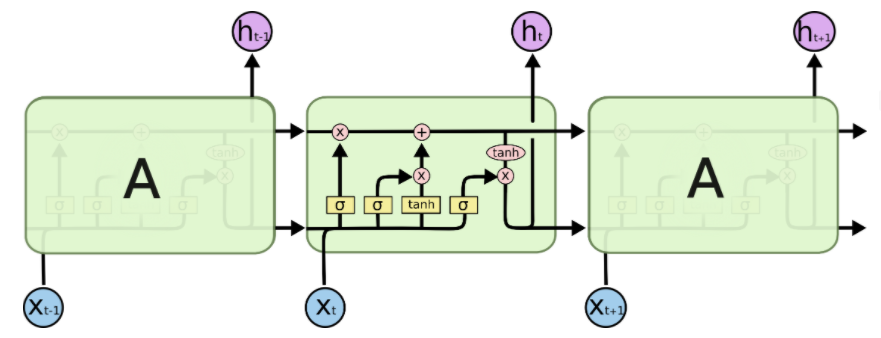


In the above diagram, each line carries an entire vector, from the output of one node to the inputs of others. The pink circles represent pointwise operations, like vector addition, while the yellow boxes are learned neural network layers. Lines merging denote concatenation, while a line forking denote its content being copied and the copies going to different locations.

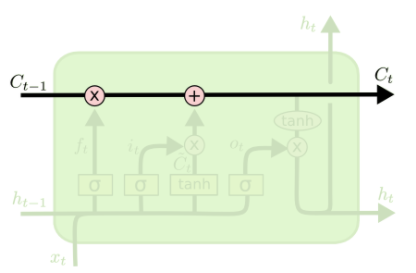

The key to LSTMs is the cell state, the horizontal line running through the top of the diagram. The cell state is kind of like a conveyor belt. It runs straight down the entire chain, with only some minor linear interactions. It’s very easy for information to just flow along it unchanged.

The LSTM does have the ability to remove or add information to the cell state, carefully regulated by structures called gates. Gates are a way to optionally let information through. They are composed out of a sigmoid neural net layer and a pointwise multiplication operation. The sigmoid layer outputs numbers between zero and one, describing how much of each component should be let through. A value of zero means “let nothing through,” while a value of one means “let everything through!”

The number of units in LSTM here is M, (i.e. M = 15). It is called the dimensionality of hidden and cell states. Also **dropout is introduced**, dropout is a regularization method where input and recurrent connections to LSTM units are probabilistically excluded from activation and weight updates while training a network. This has the effect of reducing overfitting and improving model performance.

4. **GlobalMaxPooling1D() Layer**, performs max pooling operation for 1D temporal data.

5. **Dense layer** is nothing but a regular fully-connected NN layer. In this case we are bringing down the output dimensionality to 1.

In [27]:
# Create the model

# We get to choose embedding dimensionality
D = 20

# Hidden state dimensionality
M = 15

# Note: we actually want to the size of the embedding to (V + 1) x D,
# because the first index starts from 1 and not 0.
# Thus, if the final index of the embedding matrix is V,
# then it actually must have size V + 1.

i = Input(shape=(T,))
x = Embedding(V + 1, D)(i)
x = LSTM(M, dropout=0.3, recurrent_dropout=0.3,return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(i, x)

# Fitting Model and Evaluation

The model.compile is used to setupthe compilation parameters, such as optimizer and metrics.  

**Epochs:** 

The number of epochs is a hyperparameter that defines the number times that the learning algorithm will work through the entire training dataset. The number of epochs can be set to an integer value between one and infinity. You can run the algorithm for as long as you like and even stop it using other criteria besides a fixed number of epochs, such as a change (or lack of change) in model error over time.

**BatchSize:**

The batch size is a number of samples processed before the model is updated. The size of a batch must be more than or equal to one and less than or equal to the number of samples in the training dataset.

In [28]:
# Compiling model with ADAM Optimizer (Optimizer that implements the Adam algorithm.) , 
#and setting metric to accuracy

model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


print('Training model...')
#r = model.fit(
  #data_train,
  #Y_train,
  #epochs=10,
  #validation_data=(data_test, Y_test)
#)

# We will use early stopping to avoid overfitting, our epochs may run out before reaching the set threshold though. 
epochs = 10
batch_size = 3072

history = model.fit(data_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Training model...
Epoch 1/10
938/938 [==============================] - 2008s 2s/step - loss: 0.3272 - accuracy: 0.8662 - val_loss: 0.2634 - val_accuracy: 0.8916
Epoch 2/10
938/938 [==============================] - 2005s 2s/step - loss: 0.2584 - accuracy: 0.8934 - val_loss: 0.2459 - val_accuracy: 0.8992
Epoch 3/10
938/938 [==============================] - 2006s 2s/step - loss: 0.2442 - accuracy: 0.8999 - val_loss: 0.2352 - val_accuracy: 0.9040
Epoch 4/10
938/938 [==============================] - 2009s 2s/step - loss: 0.2350 - accuracy: 0.9040 - val_loss: 0.2300 - val_accuracy: 0.9063
Epoch 5/10
938/938 [==============================] - 2015s 2s/step - loss: 0.2280 - accuracy: 0.9075 - val_loss: 0.2260 - val_accuracy: 0.9085
Epoch 6/10
938/938 [==============================] - 2015s 2s/step - loss: 0.2226 - accuracy: 0.9099 - val_loss: 0.2230 - val_accuracy: 0.9098
Epoch 7/10
938/938 [==============================] - 2018s 2s/step - loss: 0.2185 - accuracy: 0.9118 - val_loss: 0.22

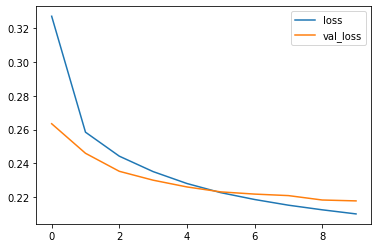

In [54]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

The blue line shows the training loss, and orange line shows validation loss. 

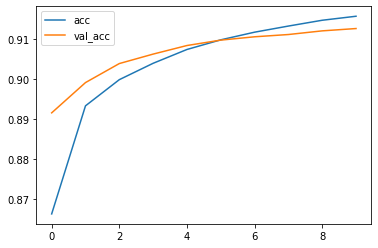

In [55]:
# Plot accuracy per iteration
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()

The blue line shows the training accuracy, and orange line shows validation accuracy. 

In [56]:
test_l,test_acc = model.evaluate(data_test, Y_test)
print(test_l, "is the Test Loss and ", test_acc, "is the test accuracy")

12500/12500 [==============================] - 255s 20ms/step - loss: 0.2189 - accuracy: 0.9122
0.21888352930545807 is the Test Loss and  0.9122474789619446 is the test accuracy


In [57]:
#making predictions using LSTM
y_hat = model.predict(data_test)
#Checking ROC score
roc_auc_score(y_true = Y_test, y_score = y_hat)

0.9710042746249999

The AUC value lies between 0.5 to 1 where 0.5 denotes a bad classifer and 1 denotes an excellent classifier.

# Model Creation, Fitting and Evaluation with different Dropout ratio.

The below code blocks are same as above but the new model runs on spatial dropout equal to **0.1**. 

In [26]:
# Create the model

# We get to choose embedding dimensionality
D = 20

# Hidden state dimensionality
M = 15

# Note: we actually want to the size of the embedding to (V + 1) x D,
# because the first index starts from 1 and not 0.
# Thus, if the final index of the embedding matrix is V,
# then it actually must have size V + 1.

i = Input(shape=(T,))
x = Embedding(V + 1, D)(i)
x = LSTM(M, dropout=0.1, recurrent_dropout=0.1,return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(1, activation='sigmoid')(x)

model2 = Model(i, x)

In [27]:
# Compile and fit
model2.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


print('Training model...')
#r = model.fit(
  #data_train,
  #Y_train,
  #epochs=10,
  #validation_data=(data_test, Y_test)
#)
epochs = 8
batch_size = 3072

history2 = model2.fit(data_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Training model...
Epoch 1/8
938/938 [==============================] - 2009s 2s/step - loss: 0.3220 - accuracy: 0.8695 - val_loss: 0.2597 - val_accuracy: 0.8927
Epoch 2/8
938/938 [==============================] - 2010s 2s/step - loss: 0.2502 - accuracy: 0.8970 - val_loss: 0.2422 - val_accuracy: 0.9006
Epoch 3/8
938/938 [==============================] - 2013s 2s/step - loss: 0.2339 - accuracy: 0.9045 - val_loss: 0.2296 - val_accuracy: 0.9067
Epoch 4/8
938/938 [==============================] - 2019s 2s/step - loss: 0.2226 - accuracy: 0.9099 - val_loss: 0.2236 - val_accuracy: 0.9097
Epoch 5/8
938/938 [==============================] - 2020s 2s/step - loss: 0.2150 - accuracy: 0.9134 - val_loss: 0.2203 - val_accuracy: 0.9112
Epoch 6/8
938/938 [==============================] - 2014s 2s/step - loss: 0.2095 - accuracy: 0.9161 - val_loss: 0.2184 - val_accuracy: 0.9121
Epoch 7/8
938/938 [==============================] - 2024s 2s/step - loss: 0.2049 - accuracy: 0.9180 - val_loss: 0.2174 - va

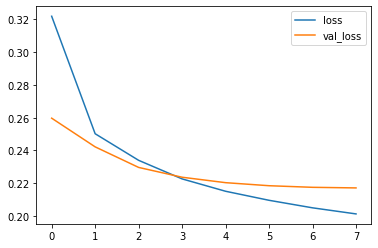

In [28]:
plt.plot(history2.history['loss'], label='loss')
plt.plot(history2.history['val_loss'], label='val_loss')
plt.legend()

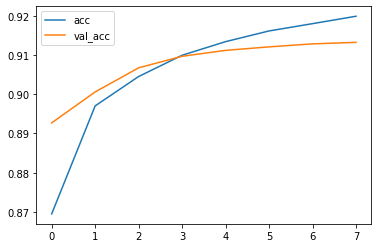

In [29]:
# Plot accuracy per iteration
plt.plot(history2.history['accuracy'], label='acc')
plt.plot(history2.history['val_accuracy'], label='val_acc')
plt.legend()

In [30]:
test_l,test_acc = model2.evaluate(data_test, Y_test)
print(test_l, "is the Test Loss and ", test_acc, "is the test accuracy")

12500/12500 [==============================] - 254s 20ms/step - loss: 0.2178 - accuracy: 0.9127
0.2177681028842926 is the Test Loss and  0.9127100110054016 is the test accuracy


In [31]:
#making predictions using LSTM
y_hat = model2.predict(data_test)
#Checking ROC score
roc_auc_score(y_true = Y_test, y_score = y_hat)

0.9712687520625001

Even dropping *Dropout ratio* to 0.1 from 0.3, the ROC score is pretty much the same, the accuracy is a little higher for both test cases and train cases. Interestingly the if we analyse the plots in both cases, the plots receved here with dropout of 0.1 show a higher split or divergence which does indicates that the model might become a little overfitted after some more epochs.  

# Batch Size 32, Results Discussed

While **setting batch size at 32, and no dropout or OOV token** the following results were obtained, it took 8 hours / epoch this was one our first and apparently most poor attempts. I had to stop this model at 4 epochs.   

Epoch 1/5
84375/84375 [==============================] - 28895s 342ms/step - loss: 0.1695 - accuracy: 0.9351 - val_loss: 0.1419 - val_accuracy: 0.9471

Epoch 2/5
84375/84375 [==============================] - 28185s 334ms/step - loss: 0.1356 - accuracy: 0.9499 - val_loss: 0.1377 - val_accuracy: 0.9492

Epoch 3/5
84375/84375 [==============================] - 29721s 352ms/step - loss: 0.1261 - accuracy: 0.9540 - val_loss: 0.1342 - val_accuracy: 0.9504

Epoch 4/5
84375/84375 [==============================] - 27726s 329ms/step - loss: 0.1201 - accuracy: 0.9566 - val_loss: 0.1367 - val_accuracy: 0.9494

The plot below shows Training Loss (blue) and Validation Loss(orange). 

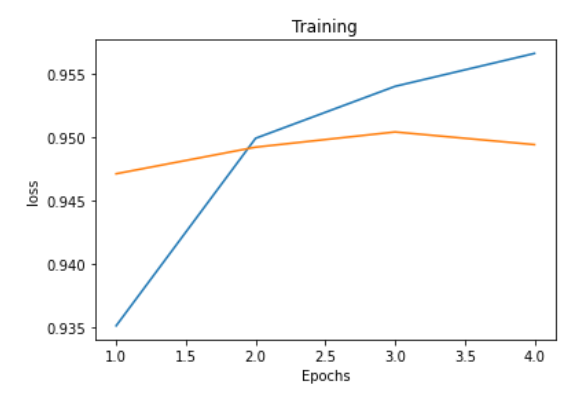

The plot below shows Training accuracy (blue) and Validation accuracy(orange). 

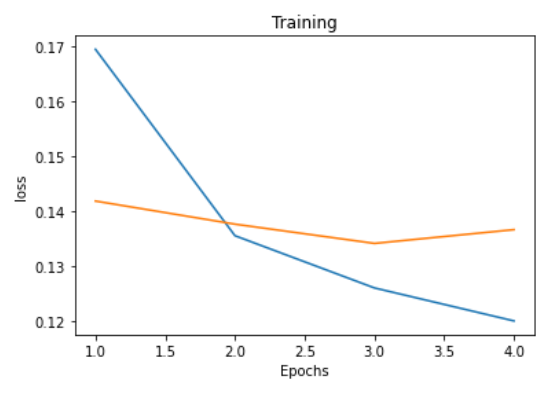

It can be observed from the above plots and information that, validation accuracy starts to decrease after 3rd epoch, meaning the model is overfiting, which is also very visible from the plots.

# GloVe - Word Embedding, Results Discussed

The **GloVe** word embedding is used in one of the versions and their results are also discussed below. 

**GloVe:**

GloVe, coined from Global Vectors, is a model for distributed word representation. The model is an **unsupervised learning** algorithm for obtaining vector representations for words. This is achieved by mapping words into a meaningful space where the distance between words is related to semantic similarity. [7]


GloVe is a **pretrained model, the difference between using GloVe and Keras Embedding Layer, is similar to difference between ImageNet and CNN8**. We have used 100d glove file, meaning vocabulary with 100 dimensions. We also tried 50d results were poor, and above 100d the Google Colab crashed. 

The embedding layer is created after reading the 100d file below.  

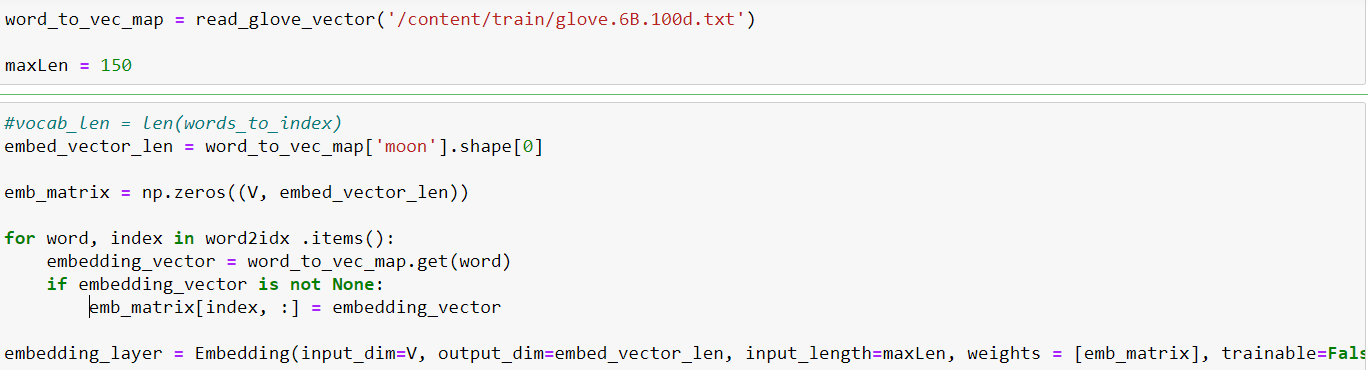

A LSTM model incorporating the embedding layer created using GloVe is intialized. 

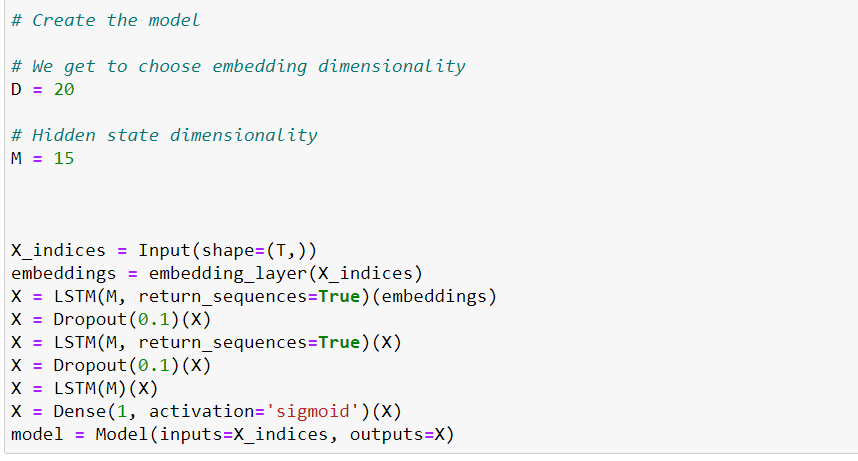

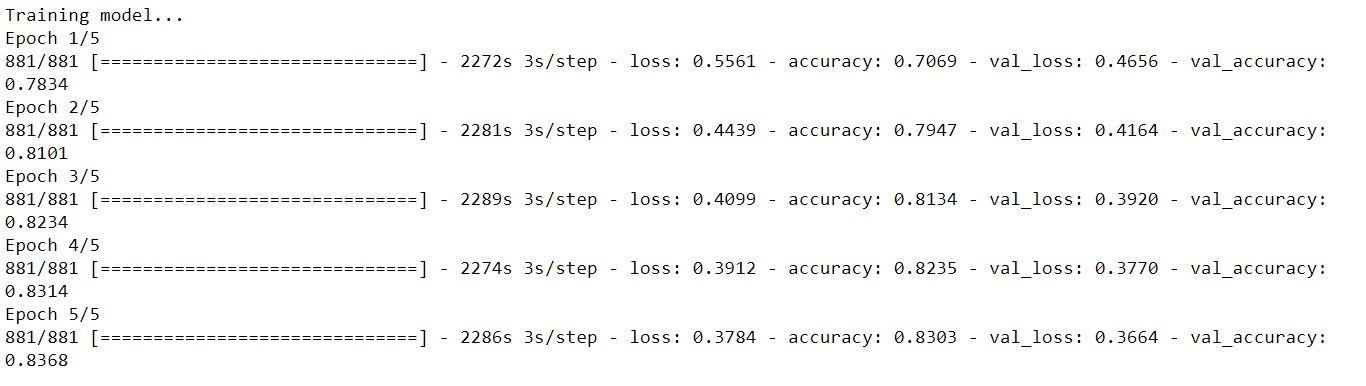

**The algorithm seems to be performing nicely and improving without a hint of overfitting uptil 5 epoch, it may seem we have stopped the algorithm pre-maturely, but in 5th epoch, while using keras.embedding layer for word embedding we had above 90 percent accuracy but here we have only 83 percent,so we choose to conclude that the Word Embedding susing Keras layer is a better option**. 

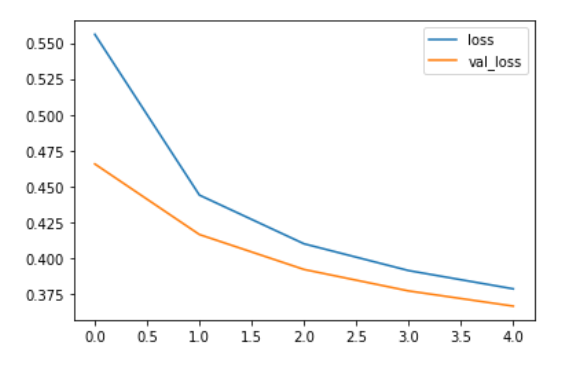

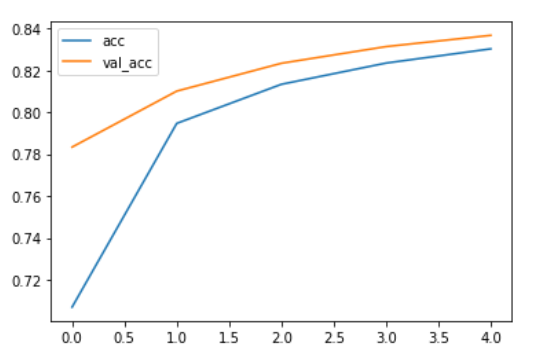


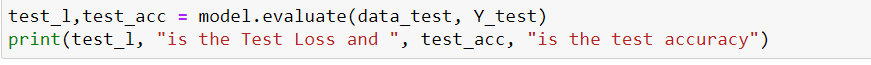

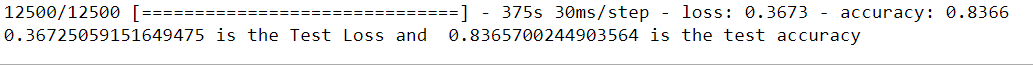

# Conclusion

Sentiment Analysis may seem a very human-type thing in the begining, because most people think that only humans can really understand the thought behing an action or a piece of writting,  but the tools and techniques developed for Natural language Processing make it easy for developer to transform this raw data into a form which can be processed by the machines and they can also understand the emotion behind text. 

The best and most stable approach which we explored here using LSTM is the one with dropout = 0.3, with OOV, Keras Embedding Layer and batch size 3072, the model didnot overfit and the results were really good i.e. 91.24 percent accuracy on test data. 

# References

1. Stemming

https://en.wikipedia.org/wiki/Stemming

2. TensorFlow Youtube Channel

https://www.youtube.com/channel/UC0rqucBdTuFTjJiefW5t-IQ

3. Use Word Embeddings layers in Deep Learning 

https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/

4. What are word embeddings ?

https://machinelearningmastery.com/what-are-word-embeddings/

5. — Page 49, Neural Network Methods in Natural Language Processing, 2017, 

https://amazon.com/Language-Processing-Synthesis-Lectures-Technologies/dp/1627052984/ref=as_li_ss_tl?ie=UTF8&qid=1502062931&sr=8-1&keywords=Neural+Network+Methods+in+Natural+Language+Processing&linkCode=sl1&tag=inspiredalgor-20&linkId=d63df073fea3ebe2d405820570b3ff03

6. Understanding LSTMs

http://colah.github.io/posts/2015-08-Understanding-LSTMs/

7. GloVe Word embedding

https://en.wikipedia.org/wiki/GloVe_(machine_learning)
